This notebook is for the purpose of running the `distillbert base uncased emotion` model hosted on huggingface. 

In [14]:
import pandas as pd
import json
import torch
import os
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import numpy as np

In [15]:
# # FINETUNED VERSION
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel
# from transformers import DistilBertModel, DistilBertTokenizer
# from sentence_transformers import SentenceTransformer

# tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
# model = SentenceTransformer('bhadresh-savani/distilbert-base-uncased-emotion')

In [16]:
# # BASE VERSION
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertTokenizer
from sentence_transformers import SentenceTransformer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [17]:
# Load data
clean_ef_data = pd.read_csv('tabulated_cleaned_emotionfiltered_trec.csv')
clean_ef_data = clean_ef_data.drop(['polarity', 'self_ref', 'PRE', 'POST'], axis=1)
print("clean emotion filtered data shape: ", clean_ef_data.shape)
clean_ef_data.head()

clean emotion filtered data shape:  (27981, 2)


,docid,TEXT
0,s_1287_153_9,I mean what the hell bro.
1,s_1287_187_0,"Yeah, crazy isn't it?"
2,s_1287_204_0,No :( sadly it doesn't have everything
3,s_1287_222_4,I'm worried.
4,s_1287_240_1,Better weapons and going against a weaker team...


In [18]:
# Load set of augmented answers
aug_answer_set = pd.read_csv('augmented_answer_sets.csv')
print("aug answer set shape: ", aug_answer_set.shape)
aug_answer_set.sample(4)

aug answer set shape:  (928, 3)


,Question,Severity,Text
640,15,2,Starting tasks requires more work than before
18,1,2,I’m feeling low
612,14,4,I feel that my looks are repulsive
179,5,1,I don’t feel very guilty


Now that we have answer sets and input text, let's create embeddings.

In [19]:
# Create tokens and vector embeddings for user posts
post_embeddings_df = clean_ef_data.copy()

post_embeddings = post_embeddings_df['TEXT'].to_list()

post_embeddings = model.encode(post_embeddings, device='cuda', show_progress_bar=True, 
                               output_value='sentence_embedding', convert_to_tensor=True)

Batches:   0%|          | 0/875 [00:00<?, ?it/s]

In [20]:
# Initialize an empty dictionary to store the embeddings
bdi_embeddings = {}

# Loop over all 21 BDI questions
for i in tqdm(range(1, 22), total=21):
    # Filter the DataFrame for the current question and severity > 1
    bdi_i_embedding_df = aug_answer_set[(aug_answer_set['Question'] == i) & (aug_answer_set['Severity'] > 1)]
    
    # Get embeddings for the filtered DataFrame
    bdi_i_embeddings = model.encode(
        bdi_i_embedding_df['Text'].to_list(), device='cuda', output_value='sentence_embedding', convert_to_tensor=True
    )
    
    # Store the embeddings in the dictionary
    bdi_embeddings[f"q{i}"] = bdi_i_embeddings

100%|██████████| 21/21 [00:00<00:00, 56.28it/s]


Now that we have embeddings for each post and the associated question, we will rank. 

The rankings will be computed for each question, and are based on the max-similarity 

between a post's embedding and the embedding array of the corresponding question.

In [21]:
cosine_similarity_dict = {}

for i in range(1, 22):

    # Get the correct embeddings list by key
    qa_embeddings = bdi_embeddings[f"q{i}"]

    # Get the max cosine similarity between each post embedding and the answer set for the current BDI question
    qi_cos_similarities = [
        torch.max(cosine_similarity(post_embedding, qa_embeddings)).item()
        for post_embedding in tqdm(post_embeddings, total=len(post_embeddings))
    ]

    # Assign these max cosine similarity rankings to the cosine similarity dictionary
    cosine_similarity_dict[f'q{i}'] = qi_cos_similarities

  0%|          | 0/27981 [00:00<?, ?it/s]

100%|██████████| 27981/27981 [00:02<00:00, 9530.97it/s]


Now that we have cosine similarities for each question, we need to assign them post ids

In [22]:
# Initialize an empty dictionary to store the rankings for each question
rankings_dict = {}

# Loop over all 21 BDI questions
for i in tqdm(range(1, 22), total=21):
    # Make a copy of the clean_ef_data DataFrame
    q_rankings = clean_ef_data.copy()
    
    # Add a 'score' column to the DataFrame, which contains the cosine similarity scores for the current question
    q_rankings['score'] = cosine_similarity_dict[f'q{i}']
    
    # Sort the DataFrame by the 'score' column in descending order and reset the index
    q_rankings = q_rankings.sort_values('score', ascending=False, ignore_index=True)
    
    # Keep only the top 1000 rows
    q_rankings = q_rankings.head(1000)
    
    # Store the DataFrame in the rankings_dict dictionary with the key as the current question
    rankings_dict[f'q{i}'] = q_rankings

100%|██████████| 21/21 [00:00<00:00, 143.40it/s]


In [9]:
# FINETUNED VERSION

# Format the rankings dict as trec-formatted content before saving to disk.
# for i, key in enumerate(rankings_dict.keys()):
#     rankings_dict[key]['query'] = f'{i+1}' # create query number
#     rankings_dict[key]['q_id'] = rankings_dict[key]['query']
#     rankings_dict[key]['doc_id'] = rankings_dict[key]['docid']
#     rankings_dict[key]['q0'] = '0'
#     rankings_dict[key]['rank'] = range(1, 1001)
#     rankings_dict[key]['rank'] = rankings_dict[key]['rank'].astype(str)
#     rankings_dict[key]['model'] = 'distilbert-base-uncased-emotion'
#     rankings_dict[key] = rankings_dict[key][["q_id", "q0", "doc_id", "score", "rank", "model"]]


In [23]:
# BASE VERSION
# Format the rankings dict as trec-formatted content before saving to disk.
for i, key in enumerate(rankings_dict.keys()):
    rankings_dict[key]['query'] = f'{i+1}' # create query number
    rankings_dict[key]['q_id'] = rankings_dict[key]['query']
    rankings_dict[key]['doc_id'] = rankings_dict[key]['docid']
    rankings_dict[key]['q0'] = '0'
    rankings_dict[key]['rank'] = range(1, 1001)
    rankings_dict[key]['rank'] = rankings_dict[key]['rank'].astype(str)
    rankings_dict[key]['model'] = 'all-MiniLM-L6-v2'
    rankings_dict[key] = rankings_dict[key][["q_id", "q0", "doc_id", "score", "rank", "model"]]


In [10]:
# for key, df in rankings_dict.items():
#     df.to_csv(f'distilbert-base-uncased-ranking-outputs/{key}_rankings.tsv', sep='\t', index=False)

In [24]:
# # Concatenate all the DataFrames in the dictionary
all_rankings = pd.concat(rankings_dict.values(), ignore_index=True)

# # Save the concatenated DataFrame as a TSV file
all_rankings.to_csv('minilm_results.tsv', sep='\t', index=False)

-----------------------------------------------------------------------------------------------------------

Now we have completed the rankings portion. We need to compare rankings against our qrels to get performance metrics.

-----------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
from sklearn.metrics import ndcg_score
import numpy as np

In [8]:
# # Read the rankings tsv file. It represents top 1000 rankings for each question.
minilm_rankings = pd.read_csv("minilm_results.tsv", sep="\t")
minilm_rankings.columns = ["query", "q0", "docid", "score", "rank", "model"]
distilbert_rankings = pd.read_csv("dbue_results.tsv", sep="\t")

In [9]:
minilm_rankings

,query,q0,docid,score,rank,model
0,1,0,s_2286_168_4,0.891695,1,all-MiniLM-L6-v2
1,1,0,s_993_781_1,0.836626,2,all-MiniLM-L6-v2
2,1,0,s_962_142_0,0.799796,3,all-MiniLM-L6-v2
3,1,0,s_326_265_1,0.791842,4,all-MiniLM-L6-v2
4,1,0,s_2100_761_0,0.770194,5,all-MiniLM-L6-v2
...,...,...,...,...,...,...
20995,21,0,s_2800_37_1,0.319181,996,all-MiniLM-L6-v2
20996,21,0,s_1265_884_4,0.319173,997,all-MiniLM-L6-v2
20997,21,0,s_1030_486_2,0.319138,998,all-MiniLM-L6-v2
20998,21,0,s_3028_163_4,0.319114,999,all-MiniLM-L6-v2


In [10]:
distilbert_rankings

,query,q0,docid,score,rank,model
0,1,0,s_993_781_1,0.997397,1,distilbert-base-uncased-emotion
1,1,0,s_2286_168_4,0.997172,2,distilbert-base-uncased-emotion
2,1,0,s_17_843_10,0.994586,3,distilbert-base-uncased-emotion
3,1,0,s_962_142_0,0.993817,4,distilbert-base-uncased-emotion
4,1,0,s_2953_456_0,0.992738,5,distilbert-base-uncased-emotion
...,...,...,...,...,...,...
20995,21,0,s_2296_272_0,0.875914,996,distilbert-base-uncased-emotion
20996,21,0,s_2504_1011_1,0.875896,997,distilbert-base-uncased-emotion
20997,21,0,s_993_560_3,0.875853,998,distilbert-base-uncased-emotion
20998,21,0,s_2459_975_2,0.875849,999,distilbert-base-uncased-emotion


In [11]:
# Load the majority qrels file
qrels_majority = pd.read_csv('task1/training/t1_training/TRAINING DATA (2023 COLLECTION)/g_qrels_majority_2.csv')
# qrels_majority['query'] = qrels_majority['query'].astype(str)
# qrels_majority.columns = ["q_id", "q0", "doc_id", "score"]
qrels_majority.head()

,query,q0,docid,rel
0,1,0,s_405_1279_15,1
1,1,0,s_2519_356_0,0
2,1,0,s_2038_51_7,1
3,1,0,s_975_61_2,1
4,1,0,s_577_923_1,1


In [12]:
# Load the consensus qrels file
qrels_consensus = pd.read_csv('task1/training/t1_training/TRAINING DATA (2023 COLLECTION)/g_rels_consenso.csv')
# qrels_consensus['query'] = qrels_consensus['query'].astype(str)
# qrels_consensus.columns = ["q_id", "q0", "doc_id", "score"]
qrels_consensus.head()

,query,q0,docid,rel
0,1,0,s_405_1279_15,1
1,1,0,s_2519_356_0,0
2,1,0,s_2038_51_7,1
3,1,0,s_975_61_2,0
4,1,0,s_577_923_1,1


Now that we have qrels and rankings for each question, let's calculate the retrieval effectiveness metrics

In [14]:
def calculate_ndcg_at_1000_per_query(ranked_docs, qrels):
    """
    Calculate the Normalized Discounted Cumulative Gain (NDCG) at 1000 for each query in a DataFrame of ranked documents.

    Parameters:
    ranked_docs (DataFrame): A DataFrame with columns 'quer', 'q0', 'docid', 'score', 'rank', and 'model', representing the ranked documents.
    qrels (DataFrame): A DataFrame with columns 'docid' and 'rel', mapping documents to their true relevance (1 if the document is relevant, 0 otherwise).

    Returns:
    list: A list of NDCG@1000 values for each query.
    """
    # Convert qrels DataFrame to dictionary for faster lookup
    qrels_dict = dict(zip(qrels['docid'], qrels['rel']))

    # Group the ranked documents by query
    grouped = ranked_docs.groupby('query')

    # Initialize a list to store the NDCG@1000 values
    ndcg_values = []

    # Loop over the groups
    for name, group in grouped:
        # Initialize a list to store the relevance scores for this group
        relevance_scores = []

        # Loop over the documents in this group
        for doc in group['docid']:
            # If the document is in the qrels file and is relevant, append 1 to the relevance scores
            if doc in qrels_dict and qrels_dict[doc] == 1:
                relevance_scores.append(1)
            # Otherwise, append 0 to the relevance scores
            else:
                relevance_scores.append(0)

        # Compute the NDCG@1000 for this group
        ndcg = ndcg_score(np.asarray([relevance_scores]), np.asarray([relevance_scores]), k=1000)

        # Append the NDCG@1000 to the list of NDCG@1000 values
        ndcg_values.append(ndcg)

    return ndcg_values

# Run it on the results for consensus and majority
distilbert_ndcg_at_1000_consensus = calculate_ndcg_at_1000_per_query(distilbert_rankings, qrels_consensus)
distilbert_ndcg_at_1000_majority = calculate_ndcg_at_1000_per_query(distilbert_rankings, qrels_majority)
minilm_ndcg_at_1000_consensus = calculate_ndcg_at_1000_per_query(minilm_rankings, qrels_consensus)
minilm_ndcg_at_1000_majority = calculate_ndcg_at_1000_per_query(minilm_rankings, qrels_majority)

In [15]:
def calculate_precision_at_10_per_query(ranked_docs, qrels):
    """
    Calculate the Precision at 10 for each query in the BDI question set.

    Parameters:
    ranked_docs (DataFrame): A DataFrame with columns 'query', 'q0', 'docid', 'score', 'rank', and 'model', representing the ranked documents.
    qrels (DataFrame): A DataFrame with columns 'docid' and 'rel', mapping documents to their true relevance (1 if the document is relevant, 0 otherwise).

    Returns:
    list: A list of Precision@10 values for each query.
    """
    # Convert qrels DataFrame to dictionary for faster lookup
    qrels_dict = dict(zip(qrels['docid'], qrels['rel']))

    # Group the ranked documents by query
    grouped = ranked_docs.groupby('query')

    # Initialize a list to store the Precision@10 values
    precision_values = []

    # Loop over the groups
    for name, group in grouped:
        # Initialize a counter for the number of relevant documents
        relevant_docs = 0

        # Loop over the top 10 documents in this group
        for doc in group['docid'][:10]:
            # If the document is in the qrels file and is relevant, increment the counter
            if doc in qrels_dict and qrels_dict[doc] == 1:
                relevant_docs += 1

        # Compute the Precision@10 for this group
        precision = relevant_docs / 10

        # Append the Precision@10 to the list of Precision@10 values
        precision_values.append(precision)

    return precision_values

# Run it on the results for consensus and majority
distilbert_precision_at_10_consensus = calculate_precision_at_10_per_query(distilbert_rankings, qrels_consensus)
distilbert_precision_at_10_majority = calculate_precision_at_10_per_query(distilbert_rankings, qrels_majority)
minilm_precision_at_10_consensus = calculate_precision_at_10_per_query(minilm_rankings, qrels_consensus)
minilm_precision_at_10_majority = calculate_precision_at_10_per_query(minilm_rankings, qrels_majority)

In [16]:
def calculate_map_per_query(ranked_docs, qrels):
    """
    Calculate the Mean Average Precision (MAP) for each query in a DataFrame of ranked documents.

    Parameters:
    ranked_docs (DataFrame): A DataFrame with columns 'q_id', 'q0', 'doc_id', 'score', 'rank', and 'model', representing the ranked documents.
    qrels (DataFrame): A DataFrame with columns 'docid' and 'rel', mapping documents to their true relevance (1 if the document is relevant, 0 otherwise).

    Returns:
    list: A list of MAP values for each query.
    """
    # Convert qrels DataFrame to dictionary for faster lookup
    qrels_dict = dict(zip(qrels['docid'], qrels['rel']))

    # Group the ranked documents by query
    grouped = ranked_docs.groupby('query')

    # Initialize a list to store the average precision values
    avg_precision_values = []

    # Loop over the groups
    for name, group in grouped:
        # Initialize a counter for the number of relevant documents and a list to store the precision values
        relevant_docs = 0
        precision_values = []

        # Loop over the documents in this group
        for i, doc in enumerate(group['docid']):
            # If the document is in the qrels file and is relevant, increment the counter and compute the precision
            if doc in qrels_dict and qrels_dict[doc] == 1:
                relevant_docs += 1
                precision = relevant_docs / (i + 1)
                precision_values.append(precision)

        # Compute the average precision for this group
        avg_precision = sum(precision_values) / len(precision_values) if precision_values else 0

        # Append the average precision to the list of average precision values
        avg_precision_values.append(avg_precision)

    return avg_precision_values

# Run it on the results for consensus and majority
distilbert_map_consensus = calculate_map_per_query(distilbert_rankings, qrels_consensus)
distilbert_map_majority = calculate_map_per_query(distilbert_rankings, qrels_majority)
minilm_map_consensus = calculate_map_per_query(minilm_rankings, qrels_consensus)
minilm_map_majority = calculate_map_per_query(minilm_rankings, qrels_majority)

In [17]:
def calculate_r_precision_per_query(ranked_docs, qrels):
    """
    Calculate the R-Precision for each query in a DataFrame of ranked documents.

    Parameters:
    ranked_docs (DataFrame): A DataFrame with columns 'q_id', 'q0', 'doc_id', 'score', 'rank', and 'model', representing the ranked documents.
    qrels (DataFrame): A DataFrame with columns 'docid' and 'rel', mapping documents to their true relevance (1 if the document is relevant, 0 otherwise).

    Returns:
    list: A list of R-Precision values for each query.
    """
    # Convert qrels DataFrame to dictionary for faster lookup
    qrels_dict = dict(zip(qrels['docid'], qrels['rel']))

    # Group the ranked documents by query
    grouped = ranked_docs.groupby('query')

    # Initialize a list to store the R-Precision values
    r_precision_values = []

    # Loop over the groups
    for name, group in grouped:
        # Count the number of relevant documents for this query
        r = sum(1 for doc in group['docid'] if doc in qrels_dict and qrels_dict[doc] == 1)

        # Initialize a counter for the number of relevant documents in the top R
        relevant_docs_in_top_r = 0

        # Loop over the top R documents in this group
        for doc in group['docid'][:r]:
            # If the document is in the qrels file and is relevant, increment the counter
            if doc in qrels_dict and qrels_dict[doc] == 1:
                relevant_docs_in_top_r += 1

        # Compute the R-Precision for this group
        r_precision = relevant_docs_in_top_r / r if r > 0 else 0

        # Append the R-Precision to the list of R-Precision values
        r_precision_values.append(r_precision)

    return r_precision_values

# Run it on the results for consensus and majority
distilbert_r_precision_consensus = calculate_r_precision_per_query(distilbert_rankings, qrels_consensus)
distilbert_r_precision_majority = calculate_r_precision_per_query(distilbert_rankings, qrels_majority)
minilm_r_precision_consensus = calculate_r_precision_per_query(minilm_rankings, qrels_consensus)
minilm_r_precision_majority = calculate_r_precision_per_query(minilm_rankings, qrels_majority)

In [18]:
# Create four dataframes to store evaluation metrics : minilm and distilbert for consensus and majority
distilbert_consensus_metrics = pd.DataFrame({
    "NDCG@1000": distilbert_ndcg_at_1000_consensus,
    "Precision@10": distilbert_precision_at_10_consensus,
    "MAP": distilbert_map_consensus,
    "R-Precision": distilbert_r_precision_consensus
})
distilbert_majority_metrics = pd.DataFrame({
    "NDCG@1000": distilbert_ndcg_at_1000_majority,
    "Precision@10": distilbert_precision_at_10_majority,
    "MAP": distilbert_map_majority,
    "R-Precision": distilbert_r_precision_majority
})
minilm_consensus_metrics = pd.DataFrame({
    "NDCG@1000": minilm_ndcg_at_1000_consensus,
    "Precision@10": minilm_precision_at_10_consensus,
    "MAP": minilm_map_consensus,
    "R-Precision": minilm_r_precision_consensus
})
minilm_majority_metrics = pd.DataFrame({
    "NDCG@1000": minilm_ndcg_at_1000_majority,
    "Precision@10": minilm_precision_at_10_majority,
    "MAP": minilm_map_majority,
    "R-Precision": minilm_r_precision_majority
})

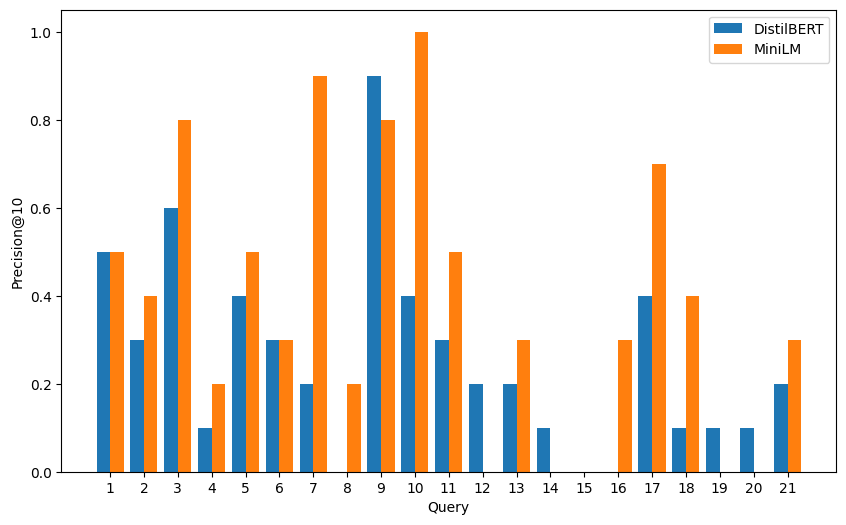

In [23]:
# Make a plot of distilbert precision@10 vs minilm precision@10 for majority
import matplotlib.pyplot as plt

import numpy as np

# Create an array with the position of each bar along the x-axis
x = np.arange(1, len(distilbert_majority_metrics["Precision@10"])+1)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, distilbert_majority_metrics["Precision@10"], 0.4, label="DistilBERT")
plt.bar(x + 0.2, minilm_majority_metrics["Precision@10"], 0.4, label="MiniLM")

# Define the labels and title
plt.xlabel("Query")
plt.ylabel("Precision@10")

# Set the x-ticks to be every integer from 1 through 21
plt.xticks(np.arange(1, 22))

# Add the legend
plt.legend()

# Show the plot
plt.show()



In [24]:
# Get p-values for differences in p@10 between distilbert and minilm
from scipy.stats import ttest_rel

p_values = [ttest_rel(distilbert_majority_metrics["Precision@10"], minilm_majority_metrics["Precision@10"]).pvalue,
            ttest_rel(distilbert_consensus_metrics["Precision@10"], minilm_consensus_metrics["Precision@10"]).pvalue]

p_values

[0.016930816485313124, 0.09757065809037589]